<h2>Download Datasets</h2>

In [15]:
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d roobansappani/hand-gesture-recognition

!unzip -q hand-gesture-recognition.zip


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/roobansappani/hand-gesture-recognition
License(s): copyright-authors
 37%|██████████████                        | 10.0M/27.1M [00:00<00:00, 35.9MB/s]
100%|██████████████████████████████████████| 27.1M/27.1M [00:00<00:00, 78.8MB/s]


<h2>Import libares</h2>

In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization,
                                      Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import glorot_uniform
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


<h2>Read Data and preprossing </h2>

In [17]:
DATASET_PATH = "/kaggle/working/HandGesture/images"
IMG_HEIGHT, IMG_WIDTH = 240, 195 

if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"The path {DATASET_PATH} does not exist.")

data = []
labels = []
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith(".jpg"):
            data.append(os.path.join(root, file))
            labels.append(os.path.basename(root))


<h2>Split data</h2>

In [18]:
df = pd.DataFrame({"Label": labels, "ImagePath": data})
print("Dataset contains:\n", df["Label"].value_counts())

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    df["ImagePath"].values, df["Label"].values, test_size=0.2, random_state=42
)

Dataset contains:
 Label
okay               540
paper              539
thumbs             537
rock_on            531
call_me            527
scissor            527
peace              526
rock               508
fingers_crossed    504
up                 504
Name: count, dtype: int64


In [19]:
def preprocess_images(image_paths, img_height, img_width):
    images = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  
        img = cv2.resize(img, (img_width, img_height))
        img = img / 255.0 
        images.append(img)
    return np.array(images).reshape(-1, img_height, img_width, 1)

x_train = preprocess_images(train_image_paths, IMG_HEIGHT, IMG_WIDTH)
x_test = preprocess_images(test_image_paths, IMG_HEIGHT, IMG_WIDTH)

In [20]:
# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

y_train = to_categorical(train_labels_encoded, num_classes=len(label_encoder.classes_))
y_test = to_categorical(test_labels_encoded, num_classes=len(label_encoder.classes_))

x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

<Axes: xlabel='Label'>

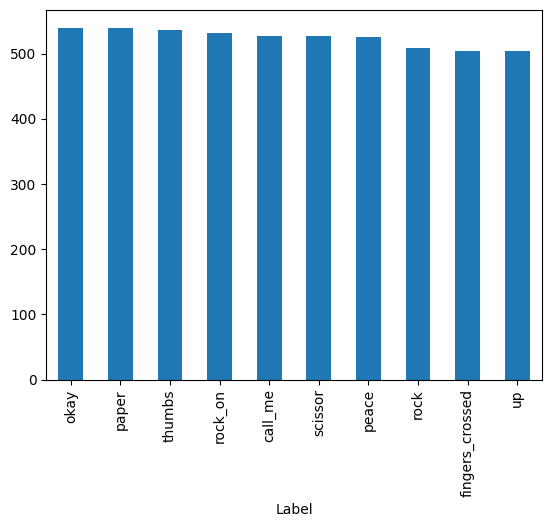

In [21]:
df["Label"].value_counts().plot(kind='bar')

<h2>Sample from dataset</h2>

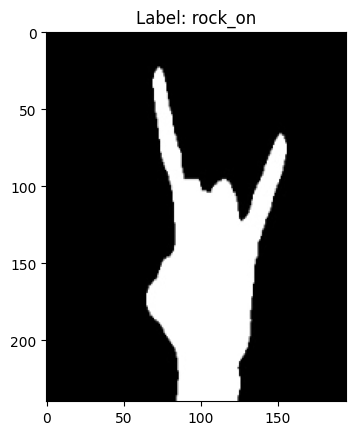

In [22]:
plt.imshow(x_train[0].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
plt.title("Label: " + label_encoder.inverse_transform([np.argmax(y_train[0])])[0])
plt.show()

<h2>ResNet50 Architect</h2>

In [23]:
def convBlock(X, f, filters, stage, block, s=2):
    F1, F2, F3 = filters
    conv_base_name = f'res{stage}{block}_branch'
    bn_base_name = f'bn{stage}{block}_branch'
    
    x_skipconnection = X

    X = Conv2D(F1, (1, 1), strides=(s, s), name=conv_base_name + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_base_name + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', name=conv_base_name + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_base_name + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides=(1, 1), name=conv_base_name + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_base_name + '2c')(X)

    x_skipconnection = Conv2D(F3, (1, 1), strides=(s, s), name=conv_base_name + '1', kernel_initializer=glorot_uniform(seed=0))(x_skipconnection)
    x_skipconnection = BatchNormalization(axis=3, name=bn_base_name + '1')(x_skipconnection)

    X = Add()([X, x_skipconnection])
    X = Activation('relu')(X)

    return X

def base_block(X, f, filters, stage, block):

    F1, F2, F3 = filters
    conv_base_name = f'res{stage}{block}_branch'
    bn_base_name = f'bn{stage}{block}_branch'

    x_skipconnection = X

    X = Conv2D(F1, (1, 1), strides=(1, 1), name=conv_base_name + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_base_name + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', name=conv_base_name + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_base_name + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides=(1, 1), name=conv_base_name + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_base_name + '2c')(X)

    X = Add()([X, x_skipconnection])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(64, 64, 3), classes=3):
    
    x_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(x_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convBlock(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = base_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = base_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convBlock(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = base_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = base_block(X, 3, [128, 128, 512], stage=3, block='c')

    # Stage 4
    X = convBlock(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = base_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = base_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = base_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = base_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = base_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convBlock(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = base_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = base_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), name="avg_pool")(X)

    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name=f'fc{classes}', kernel_regularizer=l2(0.4))(X)

    model = Model(inputs=x_input, outputs=X, name='ResNet50')

    return model


<h2>Generate model and traing the data</h2>

In [24]:
model = ResNet50(input_shape=(240, 195, 1), classes=len(label_encoder.classes_))

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

history = model.fit(x_train_split, y_train_split, validation_data=(x_val, y_val), epochs=10, batch_size=16, callbacks=[early_stopping])

Epoch 1/10


I0000 00:00:1734548235.355693     235 service.cc:145] XLA service 0x79c0ac002020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734548235.355758     235 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734548235.355765     235 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734548257.114844     235 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


210/210 ━━━━━━━━━━━━━━━━━━━━ 103s 261ms/step - accuracy: 0.1760 - loss: 39.9465 - val_accuracy: 0.2396 - val_loss: 8.1591
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 32s 151ms/step - accuracy: 0.3343 - loss: 2.1874 - val_accuracy: 0.4052 - val_loss: 2.0488
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - accuracy: 0.4832 - loss: 1.8776 - val_accuracy: 0.5268 - val_loss: 1.8109
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 34s 162ms/step - accuracy: 0.6298 - loss: 1.5017 - val_accuracy: 0.6770 - val_loss: 1.3415
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 34s 161ms/step - accuracy: 0.7440 - loss: 1.1536 - val_accuracy: 0.8010 - val_loss: 1.0829
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 33s 159ms/step - accuracy: 0.8065 - loss: 0.9756 - val_accuracy: 0.6794 - val_loss: 1.3023
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 34s 161ms/step - accuracy: 0.8285 - loss: 0.8624 - val_accuracy: 0.8725 - val_loss: 0.7367
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 34s 161ms/step - accuracy: 0.8572 - loss: 0.7922 - v

In [29]:
predection=model.evaluate(x_test,y_test)
loss=predection[0]
accuracy=predection[1]
print("LOSS: ",str(predection[0]))
print("Test Accuracy: ",str(predection[1]))

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9163 - loss: 0.5836
LOSS:  0.6145232915878296
Test Accuracy:  0.9084842801094055


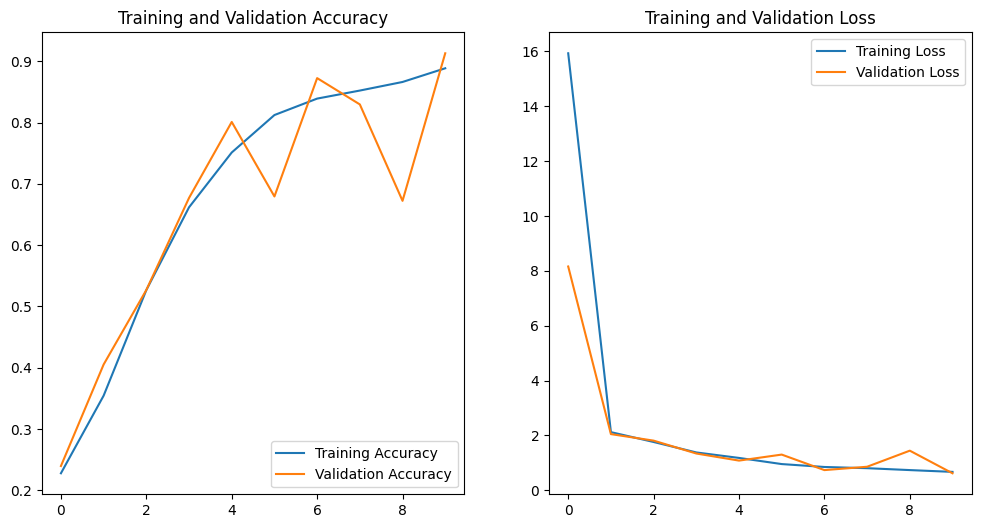

In [30]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step


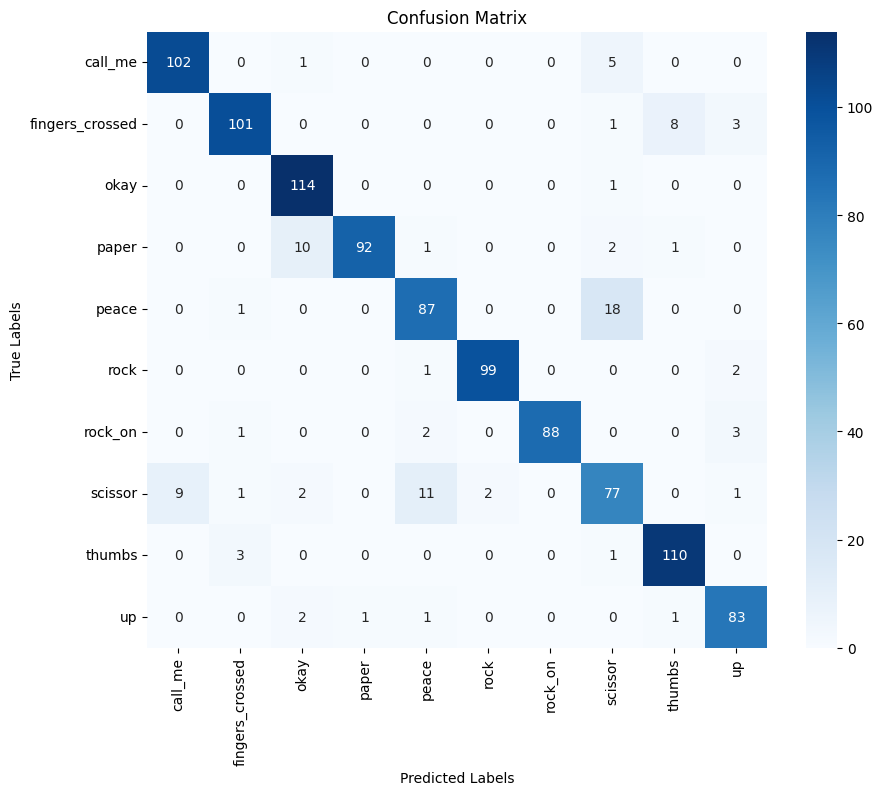

In [31]:
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_single = np.argmax(y_test, axis=1)
else:
    y_test_single = y_test

y_pred = np.argmax(model.predict(x_test), axis=1)

conf_matrix = confusion_matrix(y_test_single, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_encoder.classes_),
    yticklabels=list(label_encoder.classes_)
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [32]:
if len(y_test.shape) > 1 and y_test.shape[1] > 1: 
    y_test_single = np.argmax(y_test, axis=1)
else:
    y_test_single = y_test

y_pred_single = np.argmax(y_pred, axis=1) if len(y_pred.shape) > 1 else y_pred

class_report = classification_report(y_test_single, y_pred_single, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)


Classification Report:
                  precision    recall  f1-score   support

        call_me       0.92      0.94      0.93       108
fingers_crossed       0.94      0.89      0.92       113
           okay       0.88      0.99      0.93       115
          paper       0.99      0.87      0.92       106
          peace       0.84      0.82      0.83       106
           rock       0.98      0.97      0.98       102
        rock_on       1.00      0.94      0.97        94
        scissor       0.73      0.75      0.74       103
         thumbs       0.92      0.96      0.94       114
             up       0.90      0.94      0.92        88

       accuracy                           0.91      1049
      macro avg       0.91      0.91      0.91      1049
   weighted avg       0.91      0.91      0.91      1049



33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step


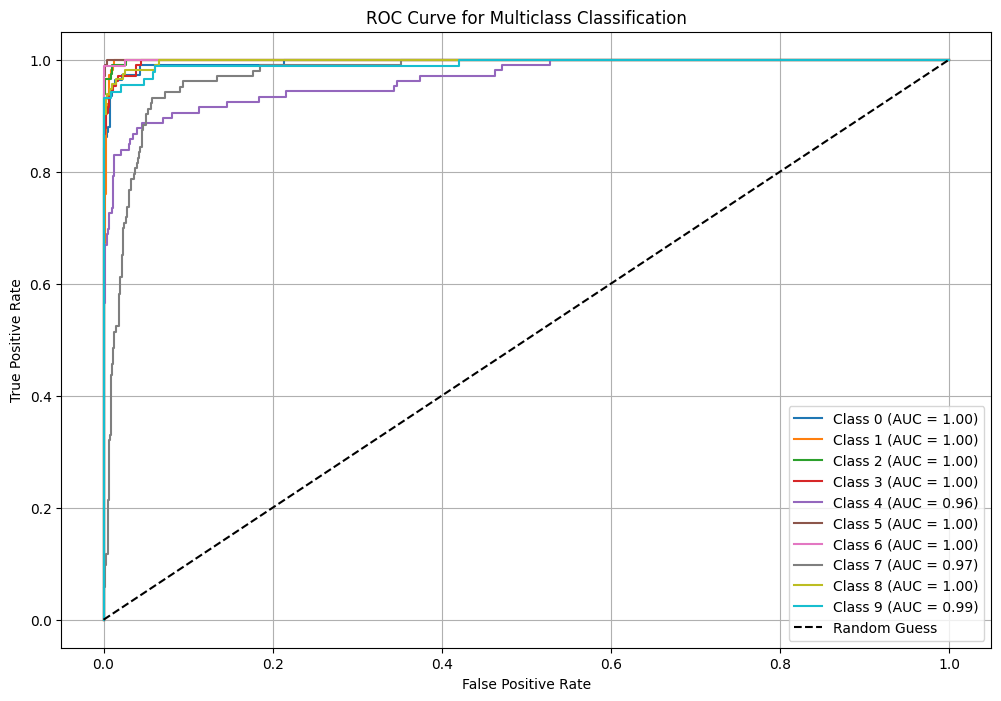

In [33]:
if len(y_test.shape) == 1: 
    y_true_one_hot = np.eye(n_classes)[y_true]
else:
    y_true_one_hot = y_test

y_pred_prob = model.predict(x_test)

n_classes = y_true_one_hot.shape[1]

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_prob[:, i]) 
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()